### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For saving models

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, precision_recall_curve, auc, ConfusionMatrixDisplay


### Load dataset

In [2]:
fraud_df = pd.read_csv(
    r"C:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\data\processed\fraud_cleaned.csv"
)
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_int,country,time_since_signup,hour_of_day,day_of_week,user_transaction_count,time_diff_hours,avg_time_between_tx
0,2,2015-01-11 03:47:13,2015-02-21 10:03:37,54,FGBQNDNBETFJJ,SEO,Chrome,F,25,8.802175e+08,0,NaN,Unknown,990.273333,10,5,1,NaN,NaN
1,4,2015-06-02 16:40:57,2015-09-26 21:32:16,41,MKFUIVOHLJBYN,Direct,Safari,F,38,2.785906e+09,0,NaN,Unknown,2788.855278,21,5,1,NaN,NaN
2,8,2015-05-28 07:53:06,2015-08-13 11:53:07,47,SCQGQALXBUQZJ,SEO,Chrome,M,25,3.560567e+08,0,NaN,Unknown,1852.000278,11,3,1,NaN,NaN
3,9,2015-05-16 15:58:32,2015-05-20 23:06:42,62,IEZOHXPZBIRTE,SEO,FireFox,M,21,7.591047e+08,0,NaN,Unknown,103.136111,23,2,1,NaN,NaN
4,12,2015-01-10 06:25:12,2015-03-04 20:56:37,35,MSNWCFEHKTIOY,Ads,Safari,M,19,2.985180e+09,0,NaN,Unknown,1286.523611,20,2,1,NaN,NaN


### Separate features and target

In [3]:
TARGET = "class"
X = fraud_df.drop(columns=[TARGET])
y = fraud_df[TARGET]

### Drop raw datetime & high-cardinality IDs

In [4]:
DROP_COLS = ["signup_time", "purchase_time", "device_id", "ip_address"]
X = X.drop(columns=DROP_COLS, errors="ignore")


### Identify categorical and numerical features

In [5]:
categorical_features = ["source", "browser", "sex", "country"]
numerical_features = [col for col in X.columns if col not in categorical_features]


### Stratified train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

Train class distribution:
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64


### Manual undersampling for class balance

In [7]:
train_df = X_train.copy()
train_df["class"] = y_train.values

fraud_minority = train_df[train_df["class"] == 1]
fraud_majority = train_df[train_df["class"] == 0].sample(n=len(fraud_minority), random_state=42)

train_balanced = pd.concat([fraud_minority, fraud_majority])
X_train_bal = train_balanced.drop(columns="class")
y_train_bal = train_balanced["class"]

print("After undersampling:")
print(y_train_bal.value_counts())

After undersampling:
class
1    11321
0    11321
Name: count, dtype: int64


### Preprocessing pipelines

In [8]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])


### Baseline Model – Logistic Regression

In [9]:
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

# Train Logistic Regression
log_reg_pipeline.fit(X_train_bal, y_train_bal)

# Evaluate Logistic Regression
y_pred_lr = log_reg_pipeline.predict(X_test)
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc_pr = average_precision_score(y_test, y_proba_lr)

print("Logistic Regression Results")
print("F1-score:", lr_f1)
print("AUC-PR:", lr_auc_pr)
print(confusion_matrix(y_test, y_pred_lr))

c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Logistic Regression Results
F1-score: 0.27351016190148125
AUC-PR: 0.43123305483695284
[[17693  9700]
 [  845  1985]]


c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


### Ensemble Model – Random Forest + Hyperparameter Tuning

In [10]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X_train_bal, y_train_bal)
best_rf = grid_search.best_estimator_

print("Best Random Forest Parameters:", grid_search.best_params_)

# Evaluate Random Forest
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc_pr = average_precision_score(y_test, y_proba_rf)

print("Random Forest Results")
print("F1-score:", rf_f1)
print("AUC-PR:", rf_auc_pr)
print(confusion_matrix(y_test, y_pred_rf))


c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Best Random Forest Parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}


c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Random Forest Results
F1-score: 0.7000686341798216
AUC-PR: 0.6354850417918413
[[27382    11]
 [ 1300  1530]]


### Cross-Validation Summary

In [13]:
cv_scores = []

for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
    X_tr, X_val = X_train_bal.iloc[train_idx], X_train_bal.iloc[val_idx]
    y_tr, y_val = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]

    best_rf.fit(X_tr, y_tr)
    y_val_proba = best_rf.predict_proba(X_val)[:, 1]

    score = average_precision_score(y_val, y_val_proba)
    cv_scores.append(score)

print("CV AUC-PR Mean:", np.mean(cv_scores))
print("CV AUC-PR Std:", np.std(cv_scores))


c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median

CV AUC-PR Mean: 0.8398965823999129
CV AUC-PR Std: 0.006579297261626389


c:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\.venv\Lib\site-packages\sklearn\impute\_base.py:653: UserWarning: Skipping features without any observed values: ['ip_int' 'time_diff_hours' 'avg_time_between_tx']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


### Model Comparison Table

In [14]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "F1-score": [lr_f1, rf_f1],
    "AUC-PR": [lr_auc_pr, rf_auc_pr]
})
print(results)

                 Model  F1-score    AUC-PR
0  Logistic Regression  0.273510  0.431233
1        Random Forest  0.700069  0.635485


### Visualizations

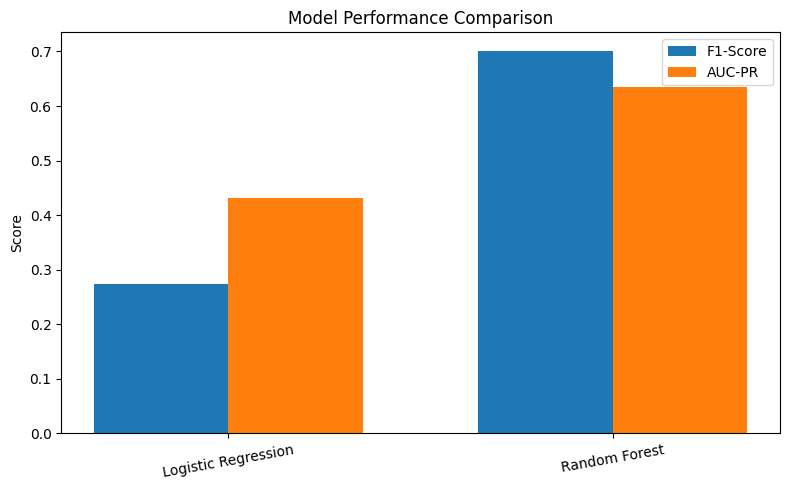

In [15]:
# Model Performance Bar Chart
models = ["Logistic Regression", "Random Forest"]
f1_scores = [lr_f1, rf_f1]
auc_pr_scores = [lr_auc_pr, rf_auc_pr]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, f1_scores, width, label="F1-Score")
plt.bar(x + width/2, auc_pr_scores, width, label="AUC-PR")
plt.xticks(x, models, rotation=10)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()


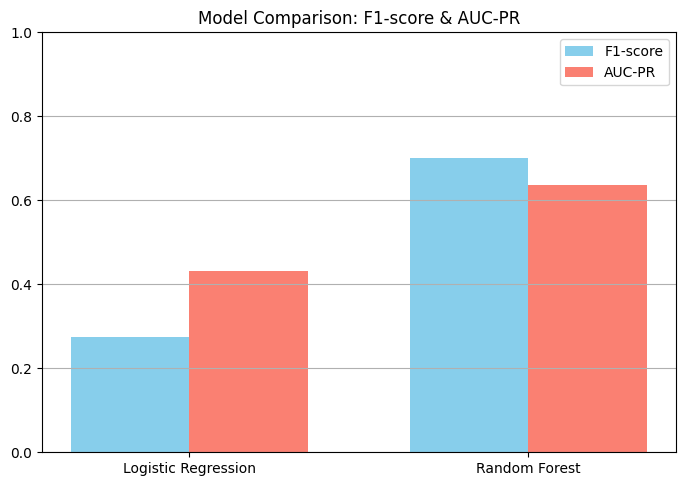

In [16]:
# Precision-Recall Curves & Confusion Matrices
fig = plt.figure(figsize=(18, 12))

# 1️⃣ Metrics Comparison Bar Chart
ax1 = fig.add_subplot(2, 2, 1)
ax1.bar(x - width/2, f1_scores, width, label='F1-score', color='skyblue')
ax1.bar(x + width/2, auc_pr_scores, width, label='AUC-PR', color='salmon')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylim(0, 1)
ax1.set_title('Model Comparison: F1-score & AUC-PR')
ax1.legend()
ax1.grid(axis='y')


### Save the best Random Forest model

In [20]:
os.makedirs("models", exist_ok=True)
joblib.dump(best_rf, r"C:\Users\Administrator\Downloads\Week 5and6\Improved_detection_of_fraud_cases\models/best_random_forest.pkl")
print("Random Forest model saved to models/best_random_forest.pkl")

Random Forest model saved to models/best_random_forest.pkl
